# Cluster analysis of image patches vectorized by EfficientNet B0

Following the approach of Ciga et al. (2021) as described in: Ciga, O., Xu, T., Nofech-Mozes, S. et al. Overcoming the limitations of patch-based learning to detect cancer in whole slide images. Sci Rep 11, 8894 (2021). https://doi.org/10.1038/s41598-021-88494-z

# Set up EfficientNet B0 with wieghts trained on ImageNet

In [41]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np   
import cv2
import h5py
import matplotlib.pyplot as plt

In [42]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [43]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [44]:
from tensorflow.keras.applications import EfficientNetB0

# Instantiate the EfficientNetB0 architecture
model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)



In [ ]:
'''
# I actually wanted to show a figure of the network but it can't find graphviz 
# Print the model summary
model.summary()
'''

Images from: https://github.com/basveeling/pcam

In [45]:
with h5py.File('/Users/scott/Desktop/cluster_test/camelyonpatch_level_2_split_train_x.h5', 'r') as file:
    # Access the 'x' dataset from the file
    x_train = file['x']

    # Get the first image from the dataset
    image = x_train[0]

    # Obtain the height, width, and channels of the image
    height, width, channels = image.shape

    print("Height:", height)
    print("Width:", width)
    print("Channels:", channels)

Height: 96
Width: 96
Channels: 3


In [46]:
#store the dataset x of the huge h5 file in the variable x_train
file = h5py.File('/Users/scott/Desktop/cluster_test/camelyonpatch_level_2_split_train_x.h5', 'r')

# Access the dataset 'x'
x_train = file['x'][:100] #Set to 100 for the trial, original number 262144

In [47]:
# Number of images (originally 262144)
print("Number of images in x_train:", x_train.shape[0])

Number of images in x_train: 100


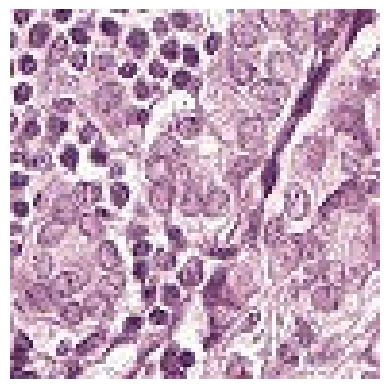

In [48]:
#show an image of your choice
image = x_train[1]  # Get the image data
plt.imshow(image)
plt.axis('off')  # Remove axis labels
plt.show()

# Get features from second to last layer (by ChatGPT)

In [49]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [50]:
# Preprocess by adjusting the images to the expected size from 96x96 --> 224x224
# Get the number of images
num_images = x_train.shape[0]

# Create an empty array for resized images
resized_images = np.empty((num_images, 224, 224, 3), dtype=np.uint8)

# Resize each image to 224x224
for i in range(num_images):
    image = x_train[i]
    resized_image = cv2.resize(image, (224, 224))
    resized_images[i] = resized_image


In [51]:
# Here I don't know wether this is necessary?

'''
The preprocessing logic has been included in the efficientnet model implementation. 
Users are no longer required to call this method to normalize the input data. 
This method does nothing and only kept as a placeholder to align 
the API surface between old and new version of model.
'''

# Preprocess the images in x_train to match the input shape of the EfficientNet-B0 model:
x_train_preprocessed = tf.keras.applications.efficientnet.preprocess_input(resized_images)

In [52]:
# Here I get the problem. This was form ChatGPT

# Obtain the features by applying 2D average pooling to the output of the pre-activation layer:
features = model(x_train_preprocessed)# it works if you write model() instead of model.predict
features_pooled = np.mean(features, axis=(1, 2))  # Apply 2D average pooling


In [53]:
# Save the features to a CSV file:
df = pd.DataFrame(features_pooled)
df.to_csv('/Users/scott/Desktop/cluster_test/features.csv', index=False)

# Yields 1280 features like in Ciga et al. (2021)

# Cluster analysis using Mini Batch K-means clustering algorithm ChatGPT

In [54]:
df = pd.read_csv('/Users/scott/Desktop/cluster_test/features.csv')
features = df.values

In [55]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

n_clusters = 10  # Number of clusters
batch_size = len(df)  # Batch size for Mini-Batch K-means
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)
kmeans.fit(features)

/Users/scott/ana/anaconda3/envs/condaenv4_tf_clustering/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(batch_size=100, n_clusters=10)

In [56]:
labels = kmeans.labels_

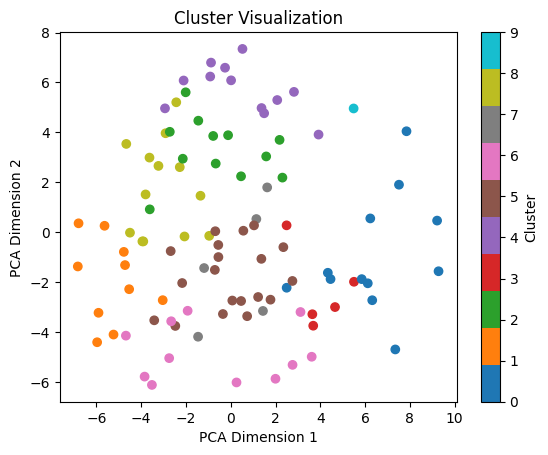

   Cluster  Count
0        0     12
1        1     10
2        2     12
3        3      5
4        4     12
5        5     19
6        6     11
7        7      5
8        8     13
9        9      1


In [62]:
# Show a plot of the clusters

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Cluster Visualization')
plt.colorbar(label='Cluster')
plt.show()

# Show points per cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()
cluster_table = pd.DataFrame({'Cluster': cluster_counts.index, 'Count': cluster_counts.values})
print(cluster_table)



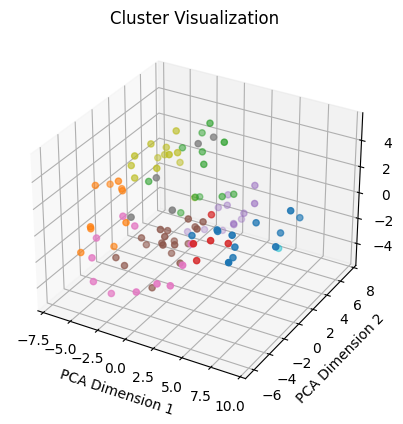

In [63]:
# Show as a 3D plot 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
features_3d = pca.fit_transform(features)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], c=labels, cmap='tab10')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
ax.set_title('Cluster Visualization')
plt.show()



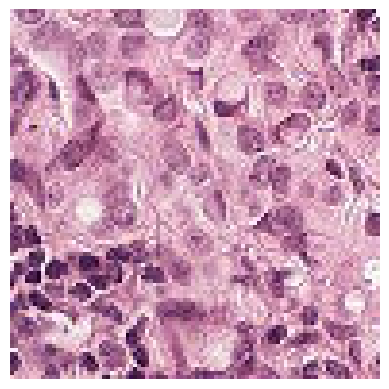

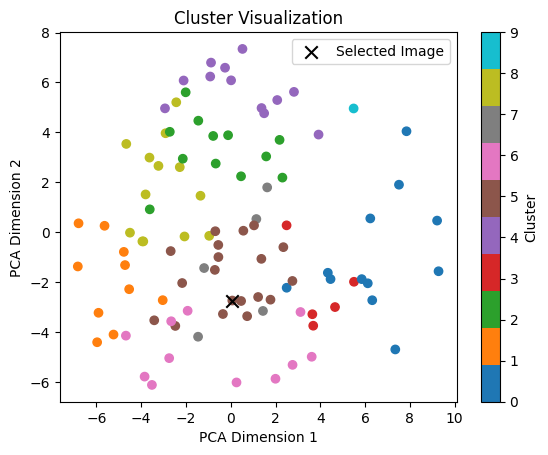

In [64]:
# Show the image of cluster 1 that is closest to the centre of that cluster 

from scipy.spatial.distance import cdist

cluster_id = 5  # Cluster ID of interest

# Retrieve indices of samples belonging to the specified cluster
cluster_indices = np.where(labels == cluster_id)[0]

# Calculate the centroid of the cluster
centroid = np.mean(features[cluster_indices], axis=0)

# Calculate the distances between the centroid and all samples in the cluster
distances = cdist(centroid.reshape(1, -1), features[cluster_indices], metric='euclidean')

# Find the index of the sample closest to the centroid
closest_index = cluster_indices[np.argmin(distances)]

# Retrieve and display the image
image = x_train[closest_index]
plt.imshow(image)
plt.axis('off')
plt.show()

# Plot the points with different colors representing different clusters

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(label='Cluster')
plt.scatter(features_2d[closest_index, 0], features_2d[closest_index, 1], color='black', marker='x', s=80, label='Selected Image')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()



In [65]:
# Show 3 images that are closest to the selected image 